# Learning with constraints

This notebook contains a very simple example showing
how to train a feedforward neural network with 
human-driven constraints.

- pytorch

## Libraries

In [37]:
import torch
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn import preprocessing

## Dataset

- dataset description
- one hot encoding
- new labels
- to torch

Load dataset the digit dataset:

One hot encoding of the supervisions:

In [38]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X, y = X[:1000], y[:1000]

print(f'X shape: {X.shape}\nClasses: {np.unique(y)}')

X shape: (1000, 784)
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [39]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y[0]

5

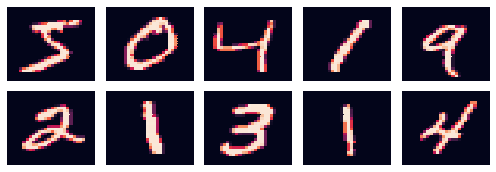

In [40]:
# show the first ten images
figs = X[:10].reshape((10, 28, 28))
plt.figure(figsize=[7, 6])
for i, fig in enumerate(figs):
    plt.subplot(5, 5, i+1)
    sns.heatmap(fig, cbar=False)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
enc = OneHotEncoder()
y1h = enc.fit_transform(y.reshape(-1, 1)).toarray()

print(f'Before: {y.shape}\nAfter: {y1h.shape}')

Before: (1000,)
After: (1000, 10)


Add new supervisions representing EVEN or ODD:

In [42]:
y2 = np.zeros((len(y), 2))
for i, yi in enumerate(y):
    if yi % 2:
        y2[i, 0] = 1
    else:
        y2[i, 1] = 1
y1h2 = np.hstack((y1h, y2))

print(f'Target vector shape: {y1h2.shape}')
for i in range(10):
    print(f'Example ({y[i]}): {y1h2[i]}')

Target vector shape: (1000, 12)
Example (5): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
Example (0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Example (4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
Example (1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Example (9): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Example (2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Example (1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Example (3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
Example (1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Example (4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]


In [43]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y1h2, test_size=0.33, random_state=42)

Transform numpy arrays into tensors:

In [44]:
x_train = torch.FloatTensor(X_train_np)
y_train = torch.FloatTensor(y_train_np)
x_test = torch.FloatTensor(X_test_np)
y_test = torch.FloatTensor(y_test_np)

## Network

In [45]:
class FeedForwardNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(FeedForwardNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h = self.linear1(x)
        h = torch.nn.functional.relu(h)
        h = self.linear2(h)
        h = torch.nn.functional.relu(h)
        h = self.linear3(h)
        y_pred = torch.sigmoid(h)
        return y_pred

Generate an instance of the network:

In [52]:
din, dh, dout = x_train.shape[1], 20, y_train.shape[1]
model = FeedForwardNet(din, dh, dout)

print(model)

FeedForwardNet(
  (linear1): Linear(in_features=784, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=12, bias=True)
)


### Loss function

In [47]:
def BCECLoss(output, targets, constraint_weight):
    sup_loss = supervision_loss(output, targets)
    constr_loss = constraint_loss(output)
    tot_loss = sup_loss + constraint_weight * constr_loss
    return tot_loss, sup_loss, constr_loss

#### Supervision loss

In [48]:
def supervision_loss(output, targets):
    return torch.nn.functional.binary_cross_entropy(output, targets, reduction="sum") / len(output)

#### Writing logical constraints

In [49]:
def constraint_loss(output, mu=10):
    # MAIN CLASSES
    ZERO = output[:, 0]
    ONE = output[:, 1]
    TWO = output[:, 2]
    THREE = output[:, 3]
    FOUR = output[:, 4]
    FIVE = output[:, 5]
    SIX = output[:, 6]
    SEVEN = output[:, 7]
    EIGHT = output[:, 8]
    NINE = output[:, 9]

    # ATTRIBUTE CLASSES
    ODD = output[:, 10]
    EVEN = output[:, 11]

    # here we converted each FOL rule using the product T-Norm (no-residual)
    loss_fol_product_tnorm = [
        # N(1,3,5,7,9) => ODD
        (ONE * (1. - ODD)),
        (THREE * (1. - ODD)),
        (FIVE * (1. - ODD)),
        (SEVEN * (1. - ODD)),
        (NINE * (1. - ODD)),

        # N(0,2,4,6,8) => EVEN
        (ZERO * (1. - EVEN)),
        (TWO * (1. - EVEN)),
        (FOUR * (1. - EVEN)),
        (SIX * (1. - EVEN)),
        (EIGHT * (1. - EVEN)),

        # XOR ON THE MAIN CLASSES
        mu * (
                (1 - ((ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (FOUR) * (1 - FIVE) * (1 - SIX) * (1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (FIVE) * (1 - SIX) * (1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (SIX) * (1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (1 - SEVEN) * (EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (1 - SEVEN) * (1 - EIGHT) * (NINE)))
              ),

        # XOR ON THE ATTRIBUTE CLASSES
        mu * (
                (EVEN) * (1 - ODD) *
                (1 - EVEN) * (ODD)
        ),
    ]

    losses = torch.sum(torch.stack(loss_fol_product_tnorm, dim=0), dim=1)
    constr_loss = torch.squeeze(torch.sum(losses, dim=0)) / len(output)
    return constr_loss

## Train loop

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()
epoch = 2000
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    tot_loss, sup_loss, constr_loss = BCECLoss(y_pred, y_train, constraint_weight=0.1)

    # compute accuracy
    y_pred_d = y_pred > 0.5
    accuracy = ((y_pred_d == y_train).sum(dim=1) == y_train.shape[1]).to(torch.float).mean()

    print(f'Epoch {epoch+1}: '
          f'total loss: {tot_loss.item():.4f} '
          f'| supervision loss: {sup_loss.item():.4f} '
          f'| constraint loss: {constr_loss.item():.4f} '
          f'| accuracy: {accuracy.detach():.4f}')

    # Backward pass
    tot_loss.backward()
    optimizer.step()

Epoch 1: total loss: 63.8826 | supervision loss: 62.4351 | constraint loss: 14.4756 | accuracy: 0.0000
Epoch 2: total loss: 59.4618 | supervision loss: 58.0423 | constraint loss: 14.1954 | accuracy: 0.0000
Epoch 3: total loss: 55.3598 | supervision loss: 53.9693 | constraint loss: 13.9051 | accuracy: 0.0000
Epoch 4: total loss: 51.7585 | supervision loss: 50.3977 | constraint loss: 13.6080 | accuracy: 0.0000
Epoch 5: total loss: 48.6118 | supervision loss: 47.2799 | constraint loss: 13.3185 | accuracy: 0.0000
Epoch 6: total loss: 45.7502 | supervision loss: 44.4456 | constraint loss: 13.0458 | accuracy: 0.0000
Epoch 7: total loss: 43.1932 | supervision loss: 41.9135 | constraint loss: 12.7970 | accuracy: 0.0000
Epoch 8: total loss: 40.9856 | supervision loss: 39.7282 | constraint loss: 12.5738 | accuracy: 0.0000
Epoch 9: total loss: 38.9862 | supervision loss: 37.7483 | constraint loss: 12.3789 | accuracy: 0.0000
Epoch 10: total loss: 37.2020 | supervision loss: 35.9806 | constraint lo

Epoch 94: total loss: 9.0556 | supervision loss: 7.8259 | constraint loss: 12.2967 | accuracy: 0.0015
Epoch 95: total loss: 9.0410 | supervision loss: 7.8116 | constraint loss: 12.2938 | accuracy: 0.0015
Epoch 96: total loss: 9.0268 | supervision loss: 7.7977 | constraint loss: 12.2910 | accuracy: 0.0015
Epoch 97: total loss: 9.0128 | supervision loss: 7.7840 | constraint loss: 12.2885 | accuracy: 0.0015
Epoch 98: total loss: 8.9993 | supervision loss: 7.7707 | constraint loss: 12.2860 | accuracy: 0.0015
Epoch 99: total loss: 8.9860 | supervision loss: 7.7576 | constraint loss: 12.2838 | accuracy: 0.0015
Epoch 100: total loss: 8.9730 | supervision loss: 7.7449 | constraint loss: 12.2816 | accuracy: 0.0015
Epoch 101: total loss: 8.9604 | supervision loss: 7.7325 | constraint loss: 12.2795 | accuracy: 0.0015
Epoch 102: total loss: 8.9480 | supervision loss: 7.7203 | constraint loss: 12.2774 | accuracy: 0.0015
Epoch 103: total loss: 8.9359 | supervision loss: 7.7084 | constraint loss: 12.

Epoch 175: total loss: 8.2483 | supervision loss: 7.0680 | constraint loss: 11.8032 | accuracy: 0.0030
Epoch 176: total loss: 8.2395 | supervision loss: 7.0597 | constraint loss: 11.7976 | accuracy: 0.0030
Epoch 177: total loss: 8.2308 | supervision loss: 7.0515 | constraint loss: 11.7932 | accuracy: 0.0015
Epoch 178: total loss: 8.2222 | supervision loss: 7.0432 | constraint loss: 11.7898 | accuracy: 0.0015
Epoch 179: total loss: 8.2138 | supervision loss: 7.0350 | constraint loss: 11.7873 | accuracy: 0.0015
Epoch 180: total loss: 8.2053 | supervision loss: 7.0267 | constraint loss: 11.7854 | accuracy: 0.0015
Epoch 181: total loss: 8.1970 | supervision loss: 7.0186 | constraint loss: 11.7838 | accuracy: 0.0015
Epoch 182: total loss: 8.1888 | supervision loss: 7.0105 | constraint loss: 11.7823 | accuracy: 0.0015
Epoch 183: total loss: 8.1808 | supervision loss: 7.0027 | constraint loss: 11.7805 | accuracy: 0.0015
Epoch 184: total loss: 8.1730 | supervision loss: 6.9952 | constraint los

Epoch 257: total loss: 7.6307 | supervision loss: 6.5095 | constraint loss: 11.2115 | accuracy: 0.0000
Epoch 258: total loss: 7.6224 | supervision loss: 6.5024 | constraint loss: 11.2001 | accuracy: 0.0000
Epoch 259: total loss: 7.6141 | supervision loss: 6.4952 | constraint loss: 11.1884 | accuracy: 0.0000
Epoch 260: total loss: 7.6056 | supervision loss: 6.4880 | constraint loss: 11.1765 | accuracy: 0.0000
Epoch 261: total loss: 7.5970 | supervision loss: 6.4806 | constraint loss: 11.1638 | accuracy: 0.0000
Epoch 262: total loss: 7.5883 | supervision loss: 6.4732 | constraint loss: 11.1512 | accuracy: 0.0015
Epoch 263: total loss: 7.5796 | supervision loss: 6.4658 | constraint loss: 11.1385 | accuracy: 0.0015
Epoch 264: total loss: 7.5708 | supervision loss: 6.4583 | constraint loss: 11.1256 | accuracy: 0.0015
Epoch 265: total loss: 7.5616 | supervision loss: 6.4504 | constraint loss: 11.1121 | accuracy: 0.0015
Epoch 266: total loss: 7.5524 | supervision loss: 6.4427 | constraint los

Epoch 340: total loss: 6.8042 | supervision loss: 5.8106 | constraint loss: 9.9363 | accuracy: 0.0090
Epoch 341: total loss: 6.7940 | supervision loss: 5.8021 | constraint loss: 9.9188 | accuracy: 0.0090
Epoch 342: total loss: 6.7837 | supervision loss: 5.7935 | constraint loss: 9.9019 | accuracy: 0.0090
Epoch 343: total loss: 6.7735 | supervision loss: 5.7850 | constraint loss: 9.8852 | accuracy: 0.0090
Epoch 344: total loss: 6.7634 | supervision loss: 5.7766 | constraint loss: 9.8684 | accuracy: 0.0104
Epoch 345: total loss: 6.7534 | supervision loss: 5.7682 | constraint loss: 9.8520 | accuracy: 0.0104
Epoch 346: total loss: 6.7433 | supervision loss: 5.7597 | constraint loss: 9.8360 | accuracy: 0.0104
Epoch 347: total loss: 6.7333 | supervision loss: 5.7513 | constraint loss: 9.8201 | accuracy: 0.0104
Epoch 348: total loss: 6.7234 | supervision loss: 5.7430 | constraint loss: 9.8041 | accuracy: 0.0104
Epoch 349: total loss: 6.7136 | supervision loss: 5.7348 | constraint loss: 9.7879

Epoch 427: total loss: 6.0446 | supervision loss: 5.1694 | constraint loss: 8.7523 | accuracy: 0.0104
Epoch 428: total loss: 6.0381 | supervision loss: 5.1633 | constraint loss: 8.7479 | accuracy: 0.0104
Epoch 429: total loss: 6.0316 | supervision loss: 5.1572 | constraint loss: 8.7439 | accuracy: 0.0104
Epoch 430: total loss: 6.0253 | supervision loss: 5.1513 | constraint loss: 8.7398 | accuracy: 0.0104
Epoch 431: total loss: 6.0190 | supervision loss: 5.1455 | constraint loss: 8.7352 | accuracy: 0.0104
Epoch 432: total loss: 6.0129 | supervision loss: 5.1399 | constraint loss: 8.7300 | accuracy: 0.0104
Epoch 433: total loss: 6.0068 | supervision loss: 5.1344 | constraint loss: 8.7244 | accuracy: 0.0104
Epoch 434: total loss: 6.0007 | supervision loss: 5.1289 | constraint loss: 8.7183 | accuracy: 0.0104
Epoch 435: total loss: 5.9947 | supervision loss: 5.1235 | constraint loss: 8.7120 | accuracy: 0.0104
Epoch 436: total loss: 5.9888 | supervision loss: 5.1182 | constraint loss: 8.7060

Epoch 516: total loss: 5.6525 | supervision loss: 4.8073 | constraint loss: 8.4518 | accuracy: 0.0493
Epoch 517: total loss: 5.6496 | supervision loss: 4.8043 | constraint loss: 8.4524 | accuracy: 0.0493
Epoch 518: total loss: 5.6466 | supervision loss: 4.8014 | constraint loss: 8.4521 | accuracy: 0.0507
Epoch 519: total loss: 5.6435 | supervision loss: 4.7984 | constraint loss: 8.4509 | accuracy: 0.0522
Epoch 520: total loss: 5.6405 | supervision loss: 4.7957 | constraint loss: 8.4486 | accuracy: 0.0552
Epoch 521: total loss: 5.6375 | supervision loss: 4.7930 | constraint loss: 8.4456 | accuracy: 0.0552
Epoch 522: total loss: 5.6346 | supervision loss: 4.7903 | constraint loss: 8.4423 | accuracy: 0.0552
Epoch 523: total loss: 5.6316 | supervision loss: 4.7877 | constraint loss: 8.4389 | accuracy: 0.0567
Epoch 524: total loss: 5.6286 | supervision loss: 4.7851 | constraint loss: 8.4356 | accuracy: 0.0567
Epoch 525: total loss: 5.6257 | supervision loss: 4.7824 | constraint loss: 8.4327

Epoch 605: total loss: 5.4386 | supervision loss: 4.6166 | constraint loss: 8.2203 | accuracy: 0.0881
Epoch 606: total loss: 5.4364 | supervision loss: 4.6148 | constraint loss: 8.2155 | accuracy: 0.0881
Epoch 607: total loss: 5.4341 | supervision loss: 4.6129 | constraint loss: 8.2119 | accuracy: 0.0881
Epoch 608: total loss: 5.4318 | supervision loss: 4.6109 | constraint loss: 8.2095 | accuracy: 0.0881
Epoch 609: total loss: 5.4295 | supervision loss: 4.6087 | constraint loss: 8.2079 | accuracy: 0.0881
Epoch 610: total loss: 5.4272 | supervision loss: 4.6065 | constraint loss: 8.2071 | accuracy: 0.0881
Epoch 611: total loss: 5.4248 | supervision loss: 4.6042 | constraint loss: 8.2058 | accuracy: 0.0896
Epoch 612: total loss: 5.4224 | supervision loss: 4.6021 | constraint loss: 8.2032 | accuracy: 0.0896
Epoch 613: total loss: 5.4199 | supervision loss: 4.6000 | constraint loss: 8.1990 | accuracy: 0.0896
Epoch 614: total loss: 5.4173 | supervision loss: 4.5980 | constraint loss: 8.1935

Epoch 691: total loss: 5.2536 | supervision loss: 4.4554 | constraint loss: 7.9824 | accuracy: 0.1149
Epoch 692: total loss: 5.2518 | supervision loss: 4.4537 | constraint loss: 7.9815 | accuracy: 0.1164
Epoch 693: total loss: 5.2500 | supervision loss: 4.4519 | constraint loss: 7.9809 | accuracy: 0.1164
Epoch 694: total loss: 5.2482 | supervision loss: 4.4502 | constraint loss: 7.9803 | accuracy: 0.1164
Epoch 695: total loss: 5.2464 | supervision loss: 4.4485 | constraint loss: 7.9793 | accuracy: 0.1164
Epoch 696: total loss: 5.2447 | supervision loss: 4.4469 | constraint loss: 7.9777 | accuracy: 0.1179
Epoch 697: total loss: 5.2429 | supervision loss: 4.4454 | constraint loss: 7.9754 | accuracy: 0.1179
Epoch 698: total loss: 5.2411 | supervision loss: 4.4439 | constraint loss: 7.9725 | accuracy: 0.1179
Epoch 699: total loss: 5.2394 | supervision loss: 4.4425 | constraint loss: 7.9691 | accuracy: 0.1179
Epoch 700: total loss: 5.2376 | supervision loss: 4.4411 | constraint loss: 7.9656

Epoch 782: total loss: 4.8562 | supervision loss: 4.1215 | constraint loss: 7.3472 | accuracy: 0.1985
Epoch 783: total loss: 4.8467 | supervision loss: 4.1139 | constraint loss: 7.3281 | accuracy: 0.2000
Epoch 784: total loss: 4.8371 | supervision loss: 4.1060 | constraint loss: 7.3108 | accuracy: 0.2000
Epoch 785: total loss: 4.8276 | supervision loss: 4.0980 | constraint loss: 7.2957 | accuracy: 0.2000
Epoch 786: total loss: 4.8185 | supervision loss: 4.0902 | constraint loss: 7.2828 | accuracy: 0.2000
Epoch 787: total loss: 4.8098 | supervision loss: 4.0827 | constraint loss: 7.2715 | accuracy: 0.2000
Epoch 788: total loss: 4.8017 | supervision loss: 4.0756 | constraint loss: 7.2608 | accuracy: 0.2000
Epoch 789: total loss: 4.7934 | supervision loss: 4.0683 | constraint loss: 7.2512 | accuracy: 0.2030
Epoch 790: total loss: 4.7856 | supervision loss: 4.0614 | constraint loss: 7.2424 | accuracy: 0.2030
Epoch 791: total loss: 4.7780 | supervision loss: 4.0546 | constraint loss: 7.2337

Epoch 865: total loss: 4.3305 | supervision loss: 3.6555 | constraint loss: 6.7506 | accuracy: 0.2119
Epoch 866: total loss: 4.3239 | supervision loss: 3.6494 | constraint loss: 6.7445 | accuracy: 0.2090
Epoch 867: total loss: 4.3173 | supervision loss: 3.6434 | constraint loss: 6.7382 | accuracy: 0.2090
Epoch 868: total loss: 4.3107 | supervision loss: 3.6375 | constraint loss: 6.7319 | accuracy: 0.2104
Epoch 869: total loss: 4.3040 | supervision loss: 3.6315 | constraint loss: 6.7258 | accuracy: 0.2104
Epoch 870: total loss: 4.2974 | supervision loss: 3.6254 | constraint loss: 6.7199 | accuracy: 0.2119
Epoch 871: total loss: 4.2906 | supervision loss: 3.6191 | constraint loss: 6.7147 | accuracy: 0.2119
Epoch 872: total loss: 4.2838 | supervision loss: 3.6128 | constraint loss: 6.7099 | accuracy: 0.2119
Epoch 873: total loss: 4.2768 | supervision loss: 3.6063 | constraint loss: 6.7051 | accuracy: 0.2119
Epoch 874: total loss: 4.2695 | supervision loss: 3.5994 | constraint loss: 6.7007

Epoch 951: total loss: 3.5979 | supervision loss: 2.9605 | constraint loss: 6.3736 | accuracy: 0.2403
Epoch 952: total loss: 3.5883 | supervision loss: 2.9513 | constraint loss: 6.3705 | accuracy: 0.2433
Epoch 953: total loss: 3.5788 | supervision loss: 2.9420 | constraint loss: 6.3674 | accuracy: 0.2448
Epoch 954: total loss: 3.5693 | supervision loss: 2.9328 | constraint loss: 6.3645 | accuracy: 0.2448
Epoch 955: total loss: 3.5598 | supervision loss: 2.9237 | constraint loss: 6.3619 | accuracy: 0.2433
Epoch 956: total loss: 3.5505 | supervision loss: 2.9146 | constraint loss: 6.3596 | accuracy: 0.2448
Epoch 957: total loss: 3.5413 | supervision loss: 2.9056 | constraint loss: 6.3568 | accuracy: 0.2448
Epoch 958: total loss: 3.5321 | supervision loss: 2.8968 | constraint loss: 6.3537 | accuracy: 0.2463
Epoch 959: total loss: 3.5231 | supervision loss: 2.8881 | constraint loss: 6.3502 | accuracy: 0.2463
Epoch 960: total loss: 3.5143 | supervision loss: 2.8796 | constraint loss: 6.3469

Epoch 1040: total loss: 2.8178 | supervision loss: 2.2374 | constraint loss: 5.8033 | accuracy: 0.3388
Epoch 1041: total loss: 2.8105 | supervision loss: 2.2311 | constraint loss: 5.7939 | accuracy: 0.3418
Epoch 1042: total loss: 2.8032 | supervision loss: 2.2247 | constraint loss: 5.7848 | accuracy: 0.3418
Epoch 1043: total loss: 2.7959 | supervision loss: 2.2183 | constraint loss: 5.7765 | accuracy: 0.3418
Epoch 1044: total loss: 2.7886 | supervision loss: 2.2118 | constraint loss: 5.7684 | accuracy: 0.3433
Epoch 1045: total loss: 2.7812 | supervision loss: 2.2052 | constraint loss: 5.7597 | accuracy: 0.3463
Epoch 1046: total loss: 2.7738 | supervision loss: 2.1987 | constraint loss: 5.7512 | accuracy: 0.3478
Epoch 1047: total loss: 2.7664 | supervision loss: 2.1921 | constraint loss: 5.7432 | accuracy: 0.3493
Epoch 1048: total loss: 2.7591 | supervision loss: 2.1856 | constraint loss: 5.7356 | accuracy: 0.3493
Epoch 1049: total loss: 2.7519 | supervision loss: 2.1791 | constraint lo

Epoch 1124: total loss: 2.2617 | supervision loss: 1.7406 | constraint loss: 5.2105 | accuracy: 0.4955
Epoch 1125: total loss: 2.2561 | supervision loss: 1.7357 | constraint loss: 5.2037 | accuracy: 0.4970
Epoch 1126: total loss: 2.2506 | supervision loss: 1.7309 | constraint loss: 5.1966 | accuracy: 0.4970
Epoch 1127: total loss: 2.2450 | supervision loss: 1.7261 | constraint loss: 5.1894 | accuracy: 0.4985
Epoch 1128: total loss: 2.2395 | supervision loss: 1.7213 | constraint loss: 5.1824 | accuracy: 0.5030
Epoch 1129: total loss: 2.2340 | supervision loss: 1.7165 | constraint loss: 5.1753 | accuracy: 0.5030
Epoch 1130: total loss: 2.2286 | supervision loss: 1.7118 | constraint loss: 5.1683 | accuracy: 0.5045
Epoch 1131: total loss: 2.2232 | supervision loss: 1.7071 | constraint loss: 5.1613 | accuracy: 0.5045
Epoch 1132: total loss: 2.2178 | supervision loss: 1.7024 | constraint loss: 5.1545 | accuracy: 0.5060
Epoch 1133: total loss: 2.2124 | supervision loss: 1.6976 | constraint lo

Epoch 1211: total loss: 1.8370 | supervision loss: 1.3742 | constraint loss: 4.6285 | accuracy: 0.5701
Epoch 1212: total loss: 1.8331 | supervision loss: 1.3709 | constraint loss: 4.6218 | accuracy: 0.5716
Epoch 1213: total loss: 1.8292 | supervision loss: 1.3677 | constraint loss: 4.6151 | accuracy: 0.5716
Epoch 1214: total loss: 1.8253 | supervision loss: 1.3644 | constraint loss: 4.6082 | accuracy: 0.5701
Epoch 1215: total loss: 1.8213 | supervision loss: 1.3612 | constraint loss: 4.6012 | accuracy: 0.5701
Epoch 1216: total loss: 1.8174 | supervision loss: 1.3580 | constraint loss: 4.5941 | accuracy: 0.5701
Epoch 1217: total loss: 1.8135 | supervision loss: 1.3548 | constraint loss: 4.5873 | accuracy: 0.5716
Epoch 1218: total loss: 1.8097 | supervision loss: 1.3516 | constraint loss: 4.5805 | accuracy: 0.5716
Epoch 1219: total loss: 1.8058 | supervision loss: 1.3485 | constraint loss: 4.5737 | accuracy: 0.5716
Epoch 1220: total loss: 1.8020 | supervision loss: 1.3453 | constraint lo

Epoch 1302: total loss: 1.5001 | supervision loss: 1.1042 | constraint loss: 3.9592 | accuracy: 0.6896
Epoch 1303: total loss: 1.4965 | supervision loss: 1.1013 | constraint loss: 3.9514 | accuracy: 0.6896
Epoch 1304: total loss: 1.4928 | supervision loss: 1.0984 | constraint loss: 3.9436 | accuracy: 0.6910
Epoch 1305: total loss: 1.4891 | supervision loss: 1.0955 | constraint loss: 3.9362 | accuracy: 0.6925
Epoch 1306: total loss: 1.4855 | supervision loss: 1.0926 | constraint loss: 3.9287 | accuracy: 0.6955
Epoch 1307: total loss: 1.4819 | supervision loss: 1.0898 | constraint loss: 3.9211 | accuracy: 0.6985
Epoch 1308: total loss: 1.4783 | supervision loss: 1.0870 | constraint loss: 3.9136 | accuracy: 0.6985
Epoch 1309: total loss: 1.4748 | supervision loss: 1.0842 | constraint loss: 3.9060 | accuracy: 0.6985
Epoch 1310: total loss: 1.4712 | supervision loss: 1.0814 | constraint loss: 3.8981 | accuracy: 0.7000
Epoch 1311: total loss: 1.4677 | supervision loss: 1.0786 | constraint lo

Epoch 1391: total loss: 1.1878 | supervision loss: 0.8633 | constraint loss: 3.2451 | accuracy: 0.7821
Epoch 1392: total loss: 1.1845 | supervision loss: 0.8607 | constraint loss: 3.2375 | accuracy: 0.7821
Epoch 1393: total loss: 1.1812 | supervision loss: 0.8582 | constraint loss: 3.2299 | accuracy: 0.7821
Epoch 1394: total loss: 1.1779 | supervision loss: 0.8557 | constraint loss: 3.2222 | accuracy: 0.7806
Epoch 1395: total loss: 1.1747 | supervision loss: 0.8532 | constraint loss: 3.2144 | accuracy: 0.7806
Epoch 1396: total loss: 1.1715 | supervision loss: 0.8508 | constraint loss: 3.2065 | accuracy: 0.7806
Epoch 1397: total loss: 1.1682 | supervision loss: 0.8484 | constraint loss: 3.1983 | accuracy: 0.7806
Epoch 1398: total loss: 1.1650 | supervision loss: 0.8460 | constraint loss: 3.1902 | accuracy: 0.7836
Epoch 1399: total loss: 1.1618 | supervision loss: 0.8435 | constraint loss: 3.1825 | accuracy: 0.7836
Epoch 1400: total loss: 1.1586 | supervision loss: 0.8411 | constraint lo

Epoch 1472: total loss: 0.9412 | supervision loss: 0.6752 | constraint loss: 2.6591 | accuracy: 0.8388
Epoch 1473: total loss: 0.9381 | supervision loss: 0.6729 | constraint loss: 2.6526 | accuracy: 0.8403
Epoch 1474: total loss: 0.9351 | supervision loss: 0.6705 | constraint loss: 2.6461 | accuracy: 0.8403
Epoch 1475: total loss: 0.9320 | supervision loss: 0.6680 | constraint loss: 2.6396 | accuracy: 0.8403
Epoch 1476: total loss: 0.9288 | supervision loss: 0.6655 | constraint loss: 2.6331 | accuracy: 0.8433
Epoch 1477: total loss: 0.9257 | supervision loss: 0.6631 | constraint loss: 2.6266 | accuracy: 0.8433
Epoch 1478: total loss: 0.9227 | supervision loss: 0.6607 | constraint loss: 2.6201 | accuracy: 0.8433
Epoch 1479: total loss: 0.9197 | supervision loss: 0.6584 | constraint loss: 2.6137 | accuracy: 0.8463
Epoch 1480: total loss: 0.9168 | supervision loss: 0.6560 | constraint loss: 2.6073 | accuracy: 0.8463
Epoch 1481: total loss: 0.9138 | supervision loss: 0.6537 | constraint lo

Epoch 1555: total loss: 0.6921 | supervision loss: 0.4814 | constraint loss: 2.1071 | accuracy: 0.8970
Epoch 1556: total loss: 0.6896 | supervision loss: 0.4795 | constraint loss: 2.1015 | accuracy: 0.8985
Epoch 1557: total loss: 0.6873 | supervision loss: 0.4777 | constraint loss: 2.0957 | accuracy: 0.9000
Epoch 1558: total loss: 0.6849 | supervision loss: 0.4759 | constraint loss: 2.0899 | accuracy: 0.9015
Epoch 1559: total loss: 0.6826 | supervision loss: 0.4742 | constraint loss: 2.0842 | accuracy: 0.9015
Epoch 1560: total loss: 0.6803 | supervision loss: 0.4725 | constraint loss: 2.0786 | accuracy: 0.9015
Epoch 1561: total loss: 0.6781 | supervision loss: 0.4707 | constraint loss: 2.0732 | accuracy: 0.9015
Epoch 1562: total loss: 0.6758 | supervision loss: 0.4690 | constraint loss: 2.0680 | accuracy: 0.9015
Epoch 1563: total loss: 0.6736 | supervision loss: 0.4673 | constraint loss: 2.0627 | accuracy: 0.9015
Epoch 1564: total loss: 0.6714 | supervision loss: 0.4656 | constraint lo

Epoch 1645: total loss: 0.5252 | supervision loss: 0.3569 | constraint loss: 1.6835 | accuracy: 0.9313
Epoch 1646: total loss: 0.5238 | supervision loss: 0.3559 | constraint loss: 1.6797 | accuracy: 0.9313
Epoch 1647: total loss: 0.5225 | supervision loss: 0.3549 | constraint loss: 1.6758 | accuracy: 0.9313
Epoch 1648: total loss: 0.5211 | supervision loss: 0.3539 | constraint loss: 1.6719 | accuracy: 0.9313
Epoch 1649: total loss: 0.5197 | supervision loss: 0.3529 | constraint loss: 1.6680 | accuracy: 0.9343
Epoch 1650: total loss: 0.5183 | supervision loss: 0.3519 | constraint loss: 1.6642 | accuracy: 0.9343
Epoch 1651: total loss: 0.5170 | supervision loss: 0.3509 | constraint loss: 1.6603 | accuracy: 0.9343
Epoch 1652: total loss: 0.5156 | supervision loss: 0.3499 | constraint loss: 1.6563 | accuracy: 0.9343
Epoch 1653: total loss: 0.5142 | supervision loss: 0.3490 | constraint loss: 1.6525 | accuracy: 0.9358
Epoch 1654: total loss: 0.5128 | supervision loss: 0.3479 | constraint lo

Epoch 1732: total loss: 0.4147 | supervision loss: 0.2794 | constraint loss: 1.3531 | accuracy: 0.9582
Epoch 1733: total loss: 0.4136 | supervision loss: 0.2787 | constraint loss: 1.3496 | accuracy: 0.9582
Epoch 1734: total loss: 0.4125 | supervision loss: 0.2779 | constraint loss: 1.3461 | accuracy: 0.9582
Epoch 1735: total loss: 0.4115 | supervision loss: 0.2772 | constraint loss: 1.3427 | accuracy: 0.9582
Epoch 1736: total loss: 0.4104 | supervision loss: 0.2765 | constraint loss: 1.3393 | accuracy: 0.9582
Epoch 1737: total loss: 0.4093 | supervision loss: 0.2757 | constraint loss: 1.3360 | accuracy: 0.9582
Epoch 1738: total loss: 0.4083 | supervision loss: 0.2750 | constraint loss: 1.3327 | accuracy: 0.9582
Epoch 1739: total loss: 0.4072 | supervision loss: 0.2743 | constraint loss: 1.3293 | accuracy: 0.9582
Epoch 1740: total loss: 0.4062 | supervision loss: 0.2736 | constraint loss: 1.3260 | accuracy: 0.9582
Epoch 1741: total loss: 0.4052 | supervision loss: 0.2729 | constraint lo

Epoch 1812: total loss: 0.3393 | supervision loss: 0.2275 | constraint loss: 1.1182 | accuracy: 0.9657
Epoch 1813: total loss: 0.3385 | supervision loss: 0.2270 | constraint loss: 1.1157 | accuracy: 0.9672
Epoch 1814: total loss: 0.3377 | supervision loss: 0.2264 | constraint loss: 1.1132 | accuracy: 0.9672
Epoch 1815: total loss: 0.3369 | supervision loss: 0.2259 | constraint loss: 1.1107 | accuracy: 0.9672
Epoch 1816: total loss: 0.3361 | supervision loss: 0.2253 | constraint loss: 1.1082 | accuracy: 0.9672
Epoch 1817: total loss: 0.3354 | supervision loss: 0.2248 | constraint loss: 1.1058 | accuracy: 0.9672
Epoch 1818: total loss: 0.3346 | supervision loss: 0.2242 | constraint loss: 1.1034 | accuracy: 0.9672
Epoch 1819: total loss: 0.3338 | supervision loss: 0.2237 | constraint loss: 1.1011 | accuracy: 0.9672
Epoch 1820: total loss: 0.3330 | supervision loss: 0.2232 | constraint loss: 1.0987 | accuracy: 0.9672
Epoch 1821: total loss: 0.3323 | supervision loss: 0.2226 | constraint lo

Epoch 1896: total loss: 0.2815 | supervision loss: 0.1880 | constraint loss: 0.9353 | accuracy: 0.9731
Epoch 1897: total loss: 0.2809 | supervision loss: 0.1876 | constraint loss: 0.9333 | accuracy: 0.9731
Epoch 1898: total loss: 0.2803 | supervision loss: 0.1872 | constraint loss: 0.9314 | accuracy: 0.9731
Epoch 1899: total loss: 0.2797 | supervision loss: 0.1868 | constraint loss: 0.9297 | accuracy: 0.9731
Epoch 1900: total loss: 0.2792 | supervision loss: 0.1864 | constraint loss: 0.9279 | accuracy: 0.9731
Epoch 1901: total loss: 0.2786 | supervision loss: 0.1860 | constraint loss: 0.9260 | accuracy: 0.9731
Epoch 1902: total loss: 0.2780 | supervision loss: 0.1856 | constraint loss: 0.9242 | accuracy: 0.9731
Epoch 1903: total loss: 0.2775 | supervision loss: 0.1852 | constraint loss: 0.9224 | accuracy: 0.9731
Epoch 1904: total loss: 0.2769 | supervision loss: 0.1848 | constraint loss: 0.9205 | accuracy: 0.9731
Epoch 1905: total loss: 0.2763 | supervision loss: 0.1845 | constraint lo

Epoch 1982: total loss: 0.2373 | supervision loss: 0.1578 | constraint loss: 0.7949 | accuracy: 0.9776
Epoch 1983: total loss: 0.2368 | supervision loss: 0.1574 | constraint loss: 0.7937 | accuracy: 0.9776
Epoch 1984: total loss: 0.2363 | supervision loss: 0.1570 | constraint loss: 0.7926 | accuracy: 0.9776
Epoch 1985: total loss: 0.2357 | supervision loss: 0.1566 | constraint loss: 0.7914 | accuracy: 0.9776
Epoch 1986: total loss: 0.2352 | supervision loss: 0.1562 | constraint loss: 0.7902 | accuracy: 0.9776
Epoch 1987: total loss: 0.2347 | supervision loss: 0.1558 | constraint loss: 0.7891 | accuracy: 0.9776
Epoch 1988: total loss: 0.2342 | supervision loss: 0.1554 | constraint loss: 0.7879 | accuracy: 0.9776
Epoch 1989: total loss: 0.2337 | supervision loss: 0.1550 | constraint loss: 0.7867 | accuracy: 0.9776
Epoch 1990: total loss: 0.2332 | supervision loss: 0.1546 | constraint loss: 0.7855 | accuracy: 0.9776
Epoch 1991: total loss: 0.2327 | supervision loss: 0.1542 | constraint lo

In [54]:
y_pred = model(x_test)

# compute accuracy
y_pred_round = y_pred > 0.5
accuracy = ((y_pred_round == y_test).sum(dim=1) == y_test.shape[1]).to(torch.float).mean()

print(f'accuracy: {accuracy.detach():.4f}')

accuracy: 0.6545


## Verification 

In [55]:
y_pred_zero = y_pred_round[y_pred_round[:, 0] == 1]
n_violations = (y_pred_zero[:, 0] != y_pred_zero[:, -1]).sum() / len(y_pred_zero)
print(f'"0 implies EVEN": {n_violations*100:.2f}% violations')

"0 implies EVEN": 0.00% violations


In [56]:
n_violations = (y_pred_round[:, -1] == y_pred_round[:, -2]).sum() / len(y_pred_round)
print(f'"XOR(EVEN, ODD)": {n_violations*100:.2f}% violations')

"XOR(EVEN, ODD)": 0.00% violations


In [57]:
n_violations = (y_pred_round[:, :-2].sum(axis=1)>1).sum() / len(y_pred_round)
print(f'"XOR(0,1,2,3,4,5,6,7,8,9)": {n_violations*100:.2f}% violations')

"XOR(0,1,2,3,4,5,6,7,8,9)": 0.00% violations


In [48]:
violations_idx = (y_pred_round[:, :-2].sum(axis=1)>1)
violations = y_pred_round[violations_idx].astype(int)

i = 1
true_class = y_test[violations_idx][i, :10].argmax().detach().numpy()
predicted_classes = y_pred_round[violations_idx][i, :10].argmax()
print(f'True class: {true_class}\nPredicted classes: {predicted_classes}')

plt.figure()
sns.heatmap(X_test[violations_idx][i].reshape((8, 8)))
plt.show()

AttributeError: 'Tensor' object has no attribute 'astype'